<a href="https://colab.research.google.com/github/racs2019/Reinforcement-Learning-Basics-Series/blob/main/Q_Learning_Maze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Q-Learning

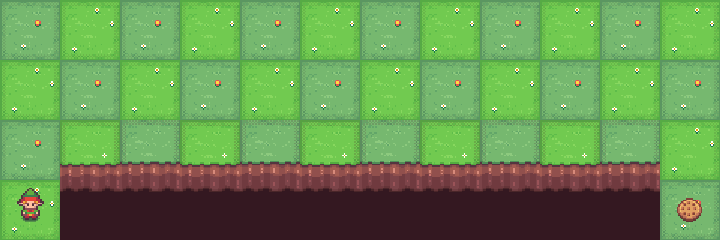

This assignment focuses on creating a Q-learning algorithm to solve a gridworld maze. Q-learning is a fundamental part of reinforcement learning, and this assignment provides a in depth demonstration of how Q-learning generates and updates Q-values through a Q-table, and how the path of the agent improves each iteration as the Q-table values approach the optima.



---



##Classes and Supporting Functions Setup

This section prepares the three main classes used to create the Q-learning maze. The agent class contains attributes which keep track of the current position of the Q-learning algorithm in the maze, and supporting functions to update its position based on a given actions and keep a running path history. The gridworld class serves to contain the maze environment that the agent will interact with. This class holds the maze layout, rewards for each state, functions to check the current state types (goal, obstacle, or none) based on a given coordinate, and a function to graphically print out the maze with the corresponding agent path. Finally, the Q-table class creates and holds the main Q-table as a pandas dataframe, and contains functions to update the Q-table, get the maximum action and value for a given state, and print the formatted table.


In [ ]:
##Dependencies
import matplotlib as mlib
import matplotlib.pyplot as plt
import numpy as np
from prettytable import PrettyTable
import random
import pandas as pd

###**Map Layout**

The cell below contains the map layout with corresponding reward values. An obstacle or boundary is represented by -10, a non-zero positive number is a goal state with the associated reward, and all other spaces are 0.



In [ ]:
##Game and reward map can be changed to modify the agent's environment and rewards
reward_map = np.array([
    [-10, -10,  -10,  -10,  -10,  -10],
    [-10,   0,    0,    0,    0,  -10],
    [-10,   0,    0,    0,    0,  -10],
    [-10,   0,    0,    0,    0,  -10],
    [-10,   0,    0,  -10,    0,  -10],
    [-10,   0,    0,  -10,  -10,  -10],
    [-10,   0,    0,    0,    0,  -10],
    [-10,   2,    0,    0,  900,  -10],
    [-10, -10,  -10,  -10,  -10,  -10]
])

###**Gridworld Class**

This class contains the environment map, functions to get the reward corresponding to the current agent position, check the current state based on the agent's position, and to graphically plot the map and path of the agent.


In [ ]:
class gridworld():

  def __init__(self, map):
    self.map = map

  ##Function to get the reward value given the position and next action
  def getReward(self, currPos, action):
    X, Y = currPos
    if (action == 'left'):
      return(self.map[Y][X-1], (X-1, Y))
    if (action == 'right'):
      return(self.map[Y][X+1], (X+1, Y))
    if (action == 'up'):
      return(self.map[Y+1][X], (X, Y+1))
    if (action == 'down'):
      return(self.map[Y-1][X], (X, Y-1))

  ##Function to check the state value given the current position
  def checkState(self, currPos):
    X, Y = currPos
    if self.map[Y][X] > 0:
      return(1)
    elif self.map[Y][X] < 0:
      return(-1)
    elif self.map[Y][X] == 0:
      return(0)

  ##Function to plot the environment and trace a path of moves
  def plot(self, moveList=[]):
    colors=['black', 'white', 'black', 'green']
    bounds=[-11, -1, 1, 1.5, 1000]
    cmap = mlib.colors.ListedColormap(colors)
    norm = mlib.colors.BoundaryNorm(bounds, cmap.N)

    plt.grid(axis='both', color='k', linewidth=2)
    plt.xticks(np.arange(0.5, self.map.shape[1], 1))
    plt.yticks(np.arange(0.5, self.map.shape[0], 1))

    plt.tick_params(bottom=False, top=False, left=False,
                    right=False, labelbottom=False, labelleft=False)
    xpoints = []
    ypoints = []
    for i in moveList:
      xpoints.append(i[0])
      ypoints.append(i[1])

    for i in range (0, len(self.map)):
      for j in range (0, len(self.map[0])):
        if self.map[i][j] > 0:
          plt.text(j,i,self.map[i][j],  ha='center', va='center')

    plt.plot(np.array(xpoints), np.array(ypoints))
    plt.imshow(self.map, cmap=cmap, norm=norm)

###**Agent Class**

This class contains attributes to store the current position of the agent, a history of previous agent positions, a function to update the position and move history based on an action, and a function to reset the agent's position and move list.

In [ ]:
class agent():

  def __init__(self, position = (1,1)):
    self.currPos = position
    self.moveList = []

  ##Function to update the position and move history of agent given an action
  def move(self, action):
      oldX, oldY = self.currPos
      if action == 'left':
        self.currPos = (oldX - 1, oldY)
        self.moveList.append((oldX, oldY))
      elif action == 'right':
        self.currPos = (oldX + 1, oldY)
        self.moveList.append((oldX, oldY))
      elif action == 'up':
        self.currPos = (oldX, oldY + 1)
        self.moveList.append((oldX, oldY))
      elif action == 'down':
        self.currPos = (oldX, oldY - 1)
        self.moveList.append((oldX, oldY))

  ##Function to reset the agent to the start
  def reset(self):
    self.currPos = (1,1)
    self.moveList.clear()

###**Q-Table Class**

This class contains a function to create the Q-table based on the map size, and a function to print the Q-table. The Q-table is implemented as a pandas dataframe, and there is a second array called mazeToTable that maps each coordinate to the corresponding row of the dataframe. To find which row of the Q-table corresponds to the coordinate/state, get the index of the mazeToTable array for a specific coordinate value. This class also contains functions to get the best action given an agent position based on the Q-table values, get the best Q-value for a given state, and to reset the Q-table.

In [ ]:
class QTable():

    ##Initialization function sets up Q table based on maze size
    def __init__(self, mazeWidth, mazeHeight):
      self.numberOfStates = mazeWidth*mazeHeight
      self.data = {
            "left": [0]*self.numberOfStates,
            "right": [0]*self.numberOfStates,
            "up": [0]*self.numberOfStates,
            "down": [0]*self.numberOfStates
            }
      self.df = pd.DataFrame(self.data)
      self.mazeToTable = []
      for i in range (1,mazeWidth+1):
        for j in range(1,mazeHeight+1):
          self.mazeToTable.append((i, j))

    ##Function to get the best action given a state
    def getBestAction(self, currPos):
      row = self.mazeToTable.index(currPos)
      maxAction = np.array([[self.df.loc[row, 'right'] ,'right'],[self.df.loc[row, 'left'] ,'left'],
                            [self.df.loc[row, 'up'] ,'up'], [self.df.loc[row, 'down'] ,'down']])
      np.random.shuffle(maxAction)
      xmax_index = np.argmax(maxAction[:, 0])
      max_action = maxAction[xmax_index][1]
      return max_action

    ##Function to get the maximum Q-value of a given state
    def getMaxValue(self, currPos):
      nextrow = self.mazeToTable.index(currPos)
      maxAction2 = np.array([self.df.loc[nextrow, 'right'],self.df.loc[nextrow, 'left'],
                             self.df.loc[nextrow, 'up'],self.df.loc[nextrow, 'down']])
      maxvalue = np.max(maxAction2)
      return maxvalue

    ##Function to print and format Q-Table
    def print(self):
      x = PrettyTable()
      x.align = 'l'
      x.field_names = ["QTable", "left", "right", "up", "down"]
      for i in range (0, self.numberOfStates):
        x.add_row([self.mazeToTable[i], round(self.df.loc[i][0], 3), round(self.df.loc[i][1],3),
                   round(self.df.loc[i][2],3), round(self.df.loc[i][3],3)])
      print(x)

    ##Function to reset the QTable
    def reset(self):
      self.df.loc[:,:] = 0

##Main QLearning Algorithm

This section contains the main Q-learning function which takes an agent, Q-table, and gridworld object as input. The function finds the maximum action of the agent given the current state, chooses either the maximum action or a random action depending on the epsilon parameter, moves the player to the next state if it is not an obstacle, and then updates the Q-value in the Q-table for the state-action pair based on the reward. Epsilon and alpha are both configurable inputs for the function, and the function requires an input float variable called error to keep track of the squared error as this function is looped through for each iteration of the main function.



In [ ]:
def QLearner(player, qt, map, epsilon, alpha, error):

    ##Part 1 - choose best action
    actionsList = ['right', 'left', 'up', 'down']
    row = qt.mazeToTable.index(player.currPos)
    max_action = qt.getBestAction(player.currPos)

    ##Part 2 - choose a random action instead of best action at a probability 1/epsilon
    e = random.randint(1,epsilon)
    if e == 1 and epsilon !=99:
      action = random.choices(actionsList, k=1)[0]
    else:
      action = max_action

    ##Part 3 - get next reward and position
    reward, nextPos = map.getReward(player.currPos, action)

    ##Part 4 - check if next position is legal (not an obstacle) and move agent if it is, set maxvalue of next state
    if map.checkState(nextPos) >=0:
      player.move(action)
      maxvalue = qt.getMaxValue(player.currPos)
    else:
      maxvalue = 0

    ##Part 5 - caclulate sum of squared TD error and update current Q-value
    OldQ = qt.df.loc[row, action]
    qt.df.loc[row, action] = 0.5 * qt.df.loc[row, action] + 0.5* (reward + (alpha)*maxvalue)
    error = error + ((qt.df.loc[row, action] - OldQ) / 0.5 )**2
    return error


##Results and Experiments

This section displays the results from running the Q-learning algorithm for different numbers of iterations. The Q-table is displayed and the map along with the final agent path based on tracing the best Q-table values is also shown. Finally, graphs showing the number of steps it took to reach the goal for each iteration and the TD error for each iteration.

###**Main function**

This section contains the main driver function which will be used to specify the number of iterations we will run the Q-learning algorithm for. The function takes a Q-table, agent, and environment object, as well as the number of iterations, the epsilon and alpha values, an array to hold the total number of steps taken during each iteration, and an array to hold the sum of squared error for each iteration as input.

In [ ]:
def  QLearningMain(qt, player, map, iterations, epsilon, alpha, total_steps, TD_error):
  ##Outer loop dictates the number of iterations
  for i in range(0,iterations):
    player.reset()
    error = 0

    ##Inner loop runs the qlearning algorithm untill a goal is reached
    while map.checkState(player.currPos) <= 0:
      error = QLearner(player, qt, map, epsilon, alpha, error)
    total_steps.append(len(player.moveList))
    TD_error.append(error)

  ##Final loop used to trace path based on learned policy (sets epsilon to zero to ensure no random actions in trace)
  player.reset()
  while map.checkState(player.currPos) <= 0:
    QLearner(player, qt, map, 99, alpha, error)
  player.moveList.append(player.currPos)

###**Iteration 10**

ITERATION 10
+--------+-------+-------+-------+------+
| QTable | left  | right | up    | down |
+--------+-------+-------+-------+------+
| (1, 1) | -8.75 | 0.0   | 0.376 | -7.5 |
| (1, 2) | -7.5  | 0.0   | 0.729 | 0.0  |
| (1, 3) | -7.5  | 0.0   | 1.113 | 0.0  |
| (1, 4) | -5.0  | 0.0   | 1.489 | 0.0  |
| (1, 5) | -5.0  | 0.0   | 1.781 | 0.0  |
| (1, 6) | -7.5  | 0.399 | 1.998 | 0.0  |
| (1, 7) | 0.0   | 0.0   | 0.0   | 0.0  |
| (2, 1) | 0.0   | 0.0   | 0.0   | -5.0 |
| (2, 2) | 0.0   | 0.0   | 0.0   | 0.0  |
| (2, 3) | 0.0   | 0.0   | 0.0   | 0.0  |
| (2, 4) | 0.0   | -5.0  | 0.182 | 0.0  |
| (2, 5) | 0.962 | 0.0   | 0.0   | 0.0  |
| (2, 6) | 1.339 | 0.0   | 0.0   | 0.0  |
| (2, 7) | 1.0   | 0.0   | -5.0  | 0.0  |
| (3, 1) | 0.0   | 0.0   | 0.0   | -5.0 |
| (3, 2) | 0.0   | 0.0   | 0.0   | 0.0  |
| (3, 3) | 0.0   | 0.0   | -7.5  | 0.0  |
| (3, 4) | 0.0   | 0.0   | 0.0   | 0.0  |
| (3, 5) | 0.0   | 0.0   | 0.0   | 0.0  |
| (3, 6) | 0.0   | 0.0   | 0.0   | 0.0  |
| (3, 7) | 0.0   | 0.

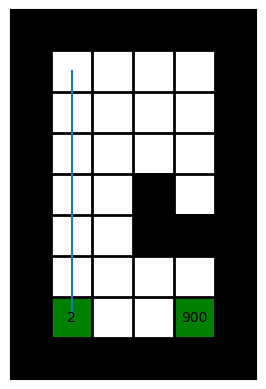

In [ ]:
qt = QTable(4, 7)
player = agent()
map = gridworld(reward_map)

iterations = 10
epsilon = 5
alpha = 0.9
total_steps = []
TD_error = []

QLearningMain(qt, player, map, iterations, epsilon, alpha, total_steps, TD_error)

print("ITERATION", iterations)
qt.print()
print('---------------')
map.plot(player.moveList)

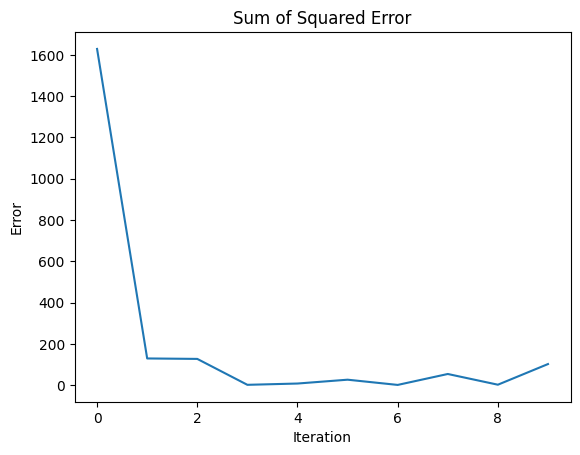

In [ ]:
plt.plot(TD_error)
plt.ylabel('Error')
plt.xlabel('Iteration')
plt.title('Sum of Squared Error')
plt.show()

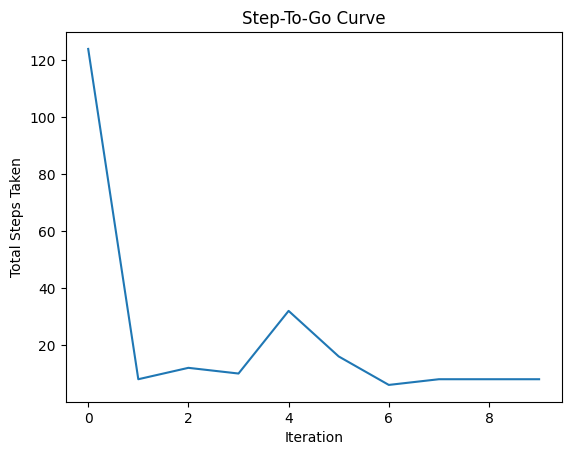

In [ ]:
plt.plot(total_steps)
plt.ylabel('Total Steps Taken')
plt.xlabel('Iteration')
plt.title('Step-To-Go Curve')
plt.show()

###**Iteration 100**

ITERATION 100
+--------+--------+--------+-------+--------+
| QTable | left   | right  | up    | down   |
+--------+--------+--------+-------+--------+
| (1, 1) | -9.844 | 0.521  | 0.957 | -9.688 |
| (1, 2) | -9.688 | 1.063  | 1.047 | 0.854  |
| (1, 3) | -9.688 | 1.181  | 0.729 | 0.0    |
| (1, 4) | -9.844 | 1.23   | 1.62  | 1.054  |
| (1, 5) | -9.688 | 1.359  | 1.8   | 1.455  |
| (1, 6) | -9.844 | 0.81   | 2.0   | 1.569  |
| (1, 7) | 0.0    | 0.0    | 0.0   | 0.0    |
| (2, 1) | 0.847  | 0.0    | 0.0   | -8.75  |
| (2, 2) | 0.789  | 0.814  | 1.181 | 0.666  |
| (2, 3) | 1.04   | 1.059  | 1.312 | 1.032  |
| (2, 4) | 1.458  | -9.98  | 1.19  | 1.153  |
| (2, 5) | 1.62   | 0.0    | 0.57  | 0.0    |
| (2, 6) | 0.9    | 0.0    | 0.0   | 1.359  |
| (2, 7) | 0.0    | 0.0    | 0.0   | 0.57   |
| (3, 1) | 0.0    | 0.0    | 0.458 | -9.688 |
| (3, 2) | 0.0    | 0.0    | 1.052 | 0.0    |
| (3, 3) | 1.181  | 0.0    | -7.5  | 0.327  |
| (3, 4) | 0.0    | 0.0    | 0.0   | 0.0    |
| (3, 5) | 0.0    | 

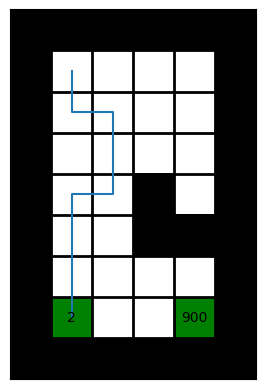

In [ ]:
qt.reset()

iterations = 100
epsilon = 5
alpha = 0.9
total_steps = []
TD_error = []

QLearningMain(qt, player, map, iterations, epsilon, alpha, total_steps, TD_error)

print("ITERATION", iterations)
qt.print()
print('---------------')
map.plot(player.moveList)

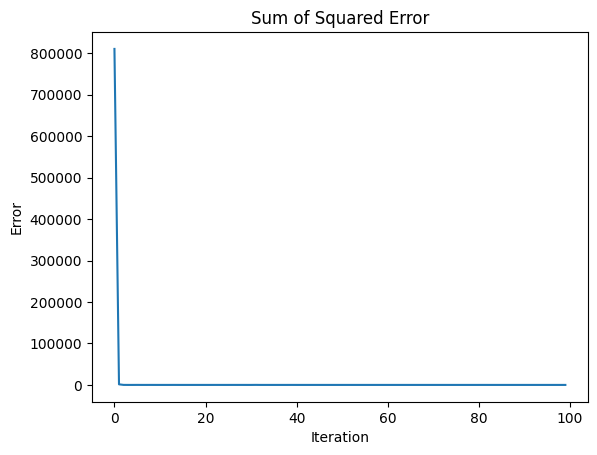

In [ ]:
plt.plot(TD_error)
plt.ylabel('Error')
plt.xlabel('Iteration')
plt.title('Sum of Squared Error')
plt.show()

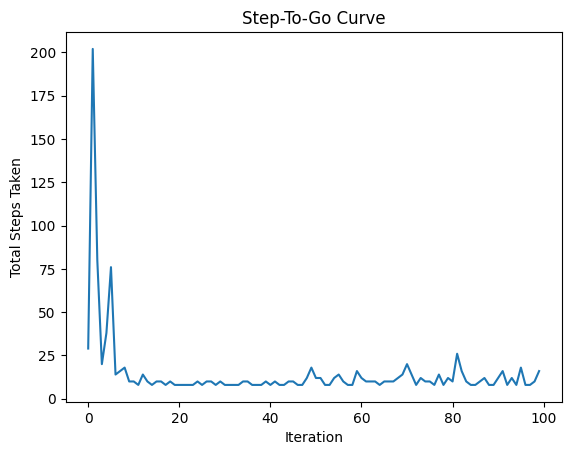

In [ ]:
plt.plot(total_steps)
plt.ylabel('Total Steps Taken')
plt.xlabel('Iteration')
plt.title('Step-To-Go Curve')
plt.show()

###**Iteration 1,000**

ITERATION 1000
+--------+-------+--------+-------+--------+
| QTable | left  | right  | up    | down   |
+--------+-------+--------+-------+--------+
| (1, 1) | -10.0 | 0.957  | 1.181 | -10.0  |
| (1, 2) | -10.0 | 1.063  | 1.312 | 1.063  |
| (1, 3) | -10.0 | 1.181  | 1.458 | 1.181  |
| (1, 4) | -10.0 | 1.312  | 1.62  | 1.312  |
| (1, 5) | -10.0 | 1.458  | 1.8   | 1.458  |
| (1, 6) | -10.0 | 1.312  | 2.0   | 1.62   |
| (1, 7) | 0.0   | 0.0    | 0.0   | 0.0    |
| (2, 1) | 1.063 | 0.457  | 0.967 | -9.844 |
| (2, 2) | 1.181 | 0.814  | 1.033 | 0.702  |
| (2, 3) | 1.312 | 0.304  | 1.138 | 0.797  |
| (2, 4) | 1.458 | -8.75  | 1.321 | 1.124  |
| (2, 5) | 1.62  | -9.961 | 1.31  | 1.299  |
| (2, 6) | 1.35  | 0.0    | 1.238 | 1.458  |
| (2, 7) | 1.875 | 0.0    | 0.0   | 0.0    |
| (3, 1) | 0.837 | 0.0    | 0.0   | -5.0   |
| (3, 2) | 1.055 | 0.0    | 0.19  | 0.0    |
| (3, 3) | 0.0   | 0.0    | -7.5  | 0.809  |
| (3, 4) | 0.0   | 0.0    | 0.0   | 0.0    |
| (3, 5) | 0.0   | 0.0    | 0.0   | 0.0 

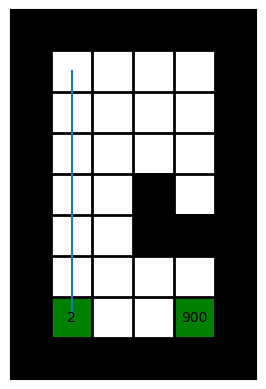

In [ ]:
qt.reset()

iterations = 1000
epsilon = 5
alpha = 0.9
total_steps = []
TD_error = []

QLearningMain(qt, player, map, iterations, epsilon, alpha, total_steps, TD_error)

print("ITERATION", iterations)
qt.print()
print('---------------')
map.plot(player.moveList)

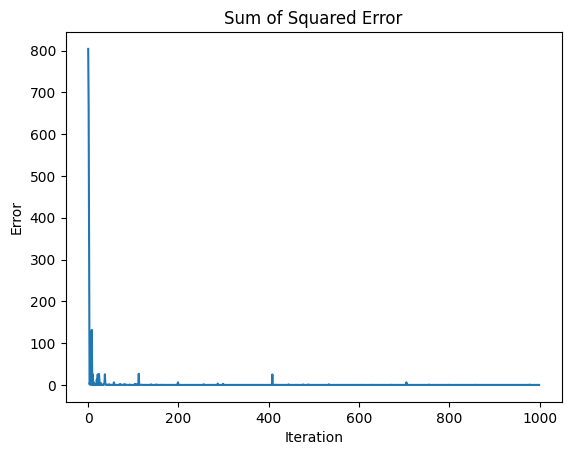

In [ ]:
plt.plot(TD_error)
plt.ylabel('Error')
plt.xlabel('Iteration')
plt.title('Sum of Squared Error')
plt.show()

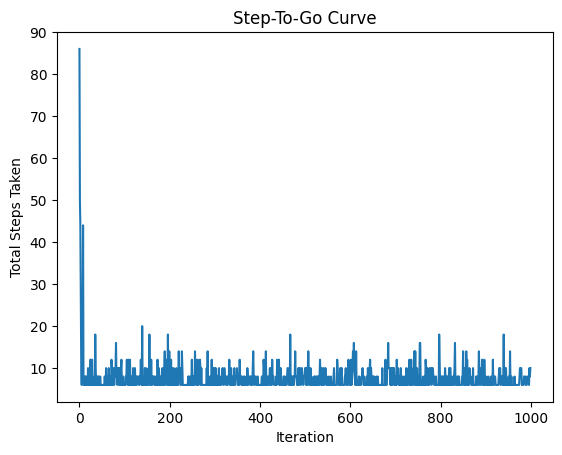

In [ ]:
plt.plot(total_steps)
plt.ylabel('Total Steps Taken')
plt.xlabel('Iteration')
plt.title('Step-To-Go Curve')
plt.show()

###**Iteration 10,000**

ITERATION 10000
+--------+---------+---------+---------+---------+
| QTable | left    | right   | up      | down    |
+--------+---------+---------+---------+---------+
| (1, 1) | -10.0   | 387.42  | 387.42  | -10.0   |
| (1, 2) | -10.0   | 430.467 | 430.467 | 348.678 |
| (1, 3) | -10.0   | 478.297 | 478.297 | 387.42  |
| (1, 4) | -10.0   | 531.441 | 531.441 | 430.467 |
| (1, 5) | -10.0   | 590.49  | 590.49  | 478.297 |
| (1, 6) | -10.0   | 656.1   | 2.0     | 531.441 |
| (1, 7) | 0.0     | 0.0     | 0.0     | 0.0     |
| (2, 1) | 348.678 | 348.678 | 430.467 | -10.0   |
| (2, 2) | 387.42  | 387.42  | 478.297 | 387.42  |
| (2, 3) | 430.467 | 430.467 | 531.441 | 430.467 |
| (2, 4) | 478.297 | -10.0   | 590.49  | 478.297 |
| (2, 5) | 531.441 | -10.0   | 656.1   | 531.441 |
| (2, 6) | 590.49  | 729.0   | 729.0   | 590.49  |
| (2, 7) | 2.0     | 810.0   | -10.0   | 656.1   |
| (3, 1) | 387.42  | 310.498 | 387.414 | -10.0   |
| (3, 2) | 430.467 | 348.677 | 430.466 | 348.678 |
| (3, 3) | 478.

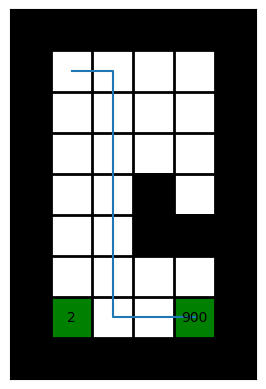

In [ ]:
qt.reset()

iterations = 10000
epsilon = 5
alpha = 0.9
total_steps = []
TD_error = []

QLearningMain(qt, player, map, iterations, epsilon, alpha, total_steps, TD_error)

print("ITERATION", iterations)
qt.print()
print('---------------')
map.plot(player.moveList)

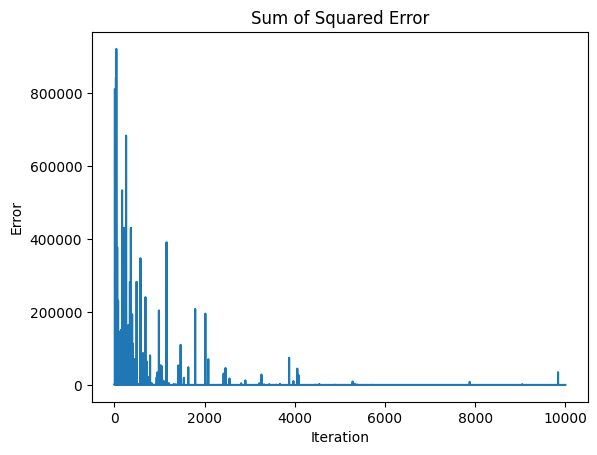

In [ ]:
plt.plot(TD_error)
plt.ylabel('Error')
plt.xlabel('Iteration')
plt.title('Sum of Squared Error')
plt.show()

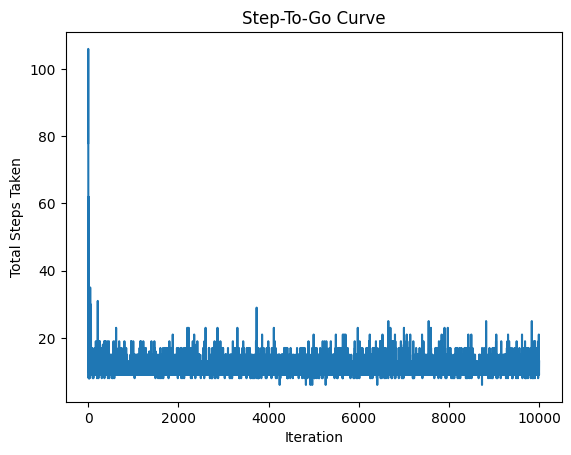

In [ ]:
plt.plot(total_steps)
plt.ylabel('Total Steps Taken')
plt.xlabel('Iteration')
plt.title('Step-To-Go Curve')
plt.show()

###**Iteration 100,000**

ITERATION 100000
+--------+---------+---------+---------+---------+
| QTable | left    | right   | up      | down    |
+--------+---------+---------+---------+---------+
| (1, 1) | -10.0   | 387.42  | 387.42  | -10.0   |
| (1, 2) | -10.0   | 430.467 | 430.467 | 348.678 |
| (1, 3) | -10.0   | 478.297 | 478.297 | 387.42  |
| (1, 4) | -10.0   | 531.441 | 531.441 | 430.467 |
| (1, 5) | -10.0   | 590.49  | 590.49  | 478.297 |
| (1, 6) | -10.0   | 656.1   | 2.0     | 531.441 |
| (1, 7) | 0.0     | 0.0     | 0.0     | 0.0     |
| (2, 1) | 348.678 | 348.678 | 430.467 | -10.0   |
| (2, 2) | 387.42  | 387.42  | 478.297 | 387.42  |
| (2, 3) | 430.467 | 430.467 | 531.441 | 430.467 |
| (2, 4) | 478.297 | -10.0   | 590.49  | 478.297 |
| (2, 5) | 531.441 | -10.0   | 656.1   | 531.441 |
| (2, 6) | 590.49  | 729.0   | 729.0   | 590.49  |
| (2, 7) | 2.0     | 810.0   | -10.0   | 656.1   |
| (3, 1) | 387.42  | 313.811 | 387.42  | -10.0   |
| (3, 2) | 430.467 | 348.678 | 430.467 | 348.678 |
| (3, 3) | 478

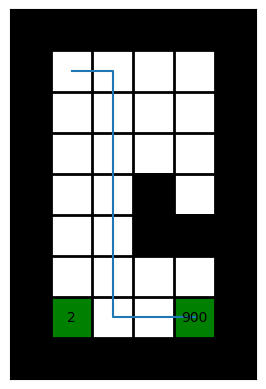

In [ ]:
qt.reset()

iterations = 100000
epsilon = 5
alpha = 0.9
total_steps = []
TD_error = []

QLearningMain(qt, player, map, iterations, epsilon, alpha, total_steps, TD_error)

print("ITERATION", iterations)
qt.print()
print('---------------')
map.plot(player.moveList)

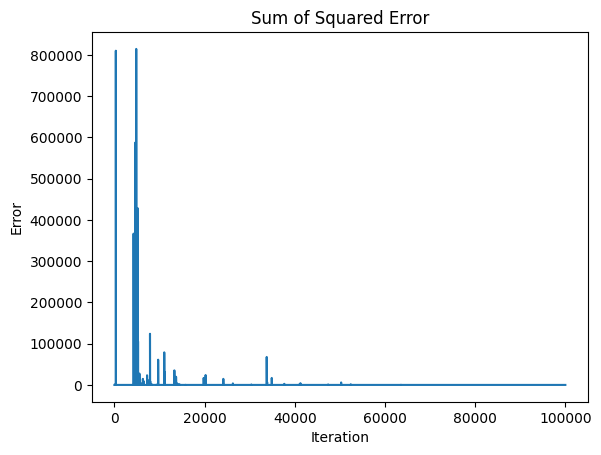

In [ ]:
plt.plot(TD_error)
plt.ylabel('Error')
plt.xlabel('Iteration')
plt.title('Sum of Squared Error')
plt.show()

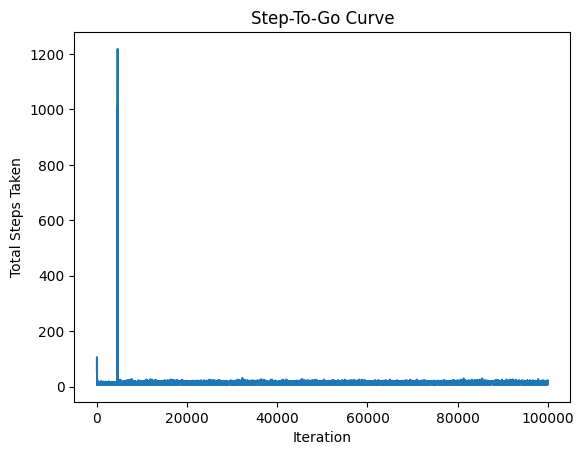

In [ ]:
plt.plot(total_steps)
plt.ylabel('Total Steps Taken')
plt.xlabel('Iteration')
plt.title('Step-To-Go Curve')
plt.show()

##Conclusions

This section discusses and analyzes the outcomes of the Q-learning experiments, focusing on the trends seen in the Q-table, error curve, and step-to-go curve as we increased the number of iterations that the algorithm ran for.

###**Trends by Iteration**

Overall, the algorithm was able to successfully converge to the optimal path and find the optimal goal state given enough iterations. I designed the map to have two goal nodes, a closer one with a simple path of low reward value and a slightly farther one with a more complicated path of significantly higher reward value. Based on this map, an optimal agent should find the shortest path to the higher reward value state if allowed to run to convergence. For the updating rule I utilized 0.5 as alpha, to given equal weight to the past and future Q-values, and I used 0.9 as gamma for the discount factor to ensure that the higher value goal will be chosen as optimal even though the lower goal is closer. After running the algorithm for 10, 100, 1000, 10000, and 100000 iterations, it became clear that it took at least 10,000 iterations for the optimal path to the far goal state to be discovered in most cases. The agent would initially find the closer and more straightforward path to the lower value goal state, and for the first few iterations it would simply exploit and reinforce this pathway and surrounding nodes. To combat this, I implemented the epsilon-greedy action selection strategy and set epsilon to a relatively high 20% for random actions. This resulted in the longer but optimal goal state eventually being found as I increased the iterations to 10,000 and 100,000. However, this also introduced noise into the error and step-to-go curves due to higher occurrence of random actions. Similarly to the trend seen in the path of the agent, the Q-table also took around 10,00 iterations to be fully explored and approach convergence, and by 100,000 iterations, the Q-table had completely converged to optimal values.


When analyzing the error and step-to-go curves for each iteration, you can see a similar trend as shown by the Q-tables and agent path. Initially, for the first few iterations, the error and number of steps required to get to the goal are high as the agent is exploring the environment and has no Q-values to direct it. After it finds the first (closer) goal state, the error and steps significantly drop off as it starts to converge to that local optimum. However, as the number of iterations increases, the random actions driven by epsilon allow the agent to explore and eventually find the optimal further goal state, which once again increases the number of steps and the error to another peak (or a few peaks) as the algorithm is shifting from choosing a path to the first goal node to learning the optimal path. Finally, after this, the error and steps-to-go both decrease to their optimal values (plus noise from the epsilon factor), and the curves converge. When running 100,000 iterations, the curves show initially high error and steps, followed by noise associated with randomly exploring and finding the optimal goal state, and then a final converged line indicating that the agent has found the optimal path and explored the entire map. The error curve becomes a horizontal line since the entire Q-table has converged, and the error is calculated using the square of temporal difference (TD) error. Temporal Difference error represents the discrepancy between the predicted value of a state or state-action pair and the actual or observed value. In this case, it can be thought of as how much the Q-values must be updated for each iteration, with a larger update meaning that it is further from the optimum and thus has a higher error. TD error can be calculated as TD_error(t) = R(t+1) + γ * max(Q(s(t+1), a')) - Q(s, a), which can also be represented as (Q(s(t+1), a’) – Q(s, a)) / alpha, which is used to calculate the sum of squared error during the update process in the main Q-learning function.


###**Final Thoughts**

Overall, this assignment demonstrated the fundamental power behind reinforcement learning, as well as the importance of balancing exploration and exploitation for an effective algorithm. I have not used reinforcement learning before, and it surprised me how learning based only on a feedback signal (and no labels) can be so effective. However, as I was experimenting with the algorithm iterations, I noticed that I needed a relatively large epsilon (0.20) in order to allow the algorithm to converge in a reasonable number of iterations. Smaller epsilons quickly converged on the local maximum goal state in a situation given two states and took longer to find the optimal goal state than a larger epsilon. However, a larger epsilon also contributed to a significantly higher runtime required due to more steps per iteration from random actions, making balancing exploration and exploitation important when deciding on the epsilon value. I look forward to the next project where I will see the possible differences that will arise from implementing a deep neural network to approximate the Q or V table.